# Homework 4
### Part 1
In this part we will continue looking at image registration but in a 3D world. Instead of computing homographies we will compute fundamental matrices between images while using the Buddha dataset. The common points can then be projected into the 3D world and we can build a sparse reconstruction.

In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np
import math
import glob
import os
import itertools

from hw3_defs import normalize_images, grayscale_images, find_features, get_matches, get_all_matches
from fundamental_matrix import getFundamentalMat, F_from_ransac, drawlines, RansacModel

In [2]:
# Save images in a list
imgs = []
dir_name = 'buddha_images/'
list_of_files = sorted( filter( os.path.isfile, glob.glob(dir_name + '*')))
for file_path in list_of_files: imgs.append(cv2.cvtColor(cv2.imread(file_path),cv2.COLOR_BGR2RGB))

imgs_norm = normalize_images(imgs)
imgs_gray = grayscale_images(imgs_norm)
img_h, img_w = imgs_gray[0].shape

In [3]:
# Same Hyperparameter settings as HW3
sift = cv2.SIFT_create(nfeatures=5000, nOctaveLayers=16, contrastThreshold=0.025, edgeThreshold=10, sigma=1.4)

kp, des, imgs_sift = find_features(sift, imgs_gray)

ptsList, goodMatchList = get_all_matches(kp, des, print_matches=False)

In [6]:
# camera matrix
K = np.array([[1, 0, img_w/2],
             [0, 1, img_h/2],
             [0, 0, 1]])

## Fundamental Matrix
From https://docs.opencv.org/3.4/da/de9/tutorial_py_epipolar_geometry.html#:~:text=In%20simple%20words%2C%20Fundamental%20Matrix,using%208%2Dpoint%20algorithm).

In [5]:
Flist = []
inlier_pts = []
for i in range(len(imgs_gray)-1):
    F, mask, (pts1,pts2) = getFundamentalMat(ptsList[i][0],ptsList[i][1])
    Flist.append(F)
    inlier_pts.append((pts1,pts2))

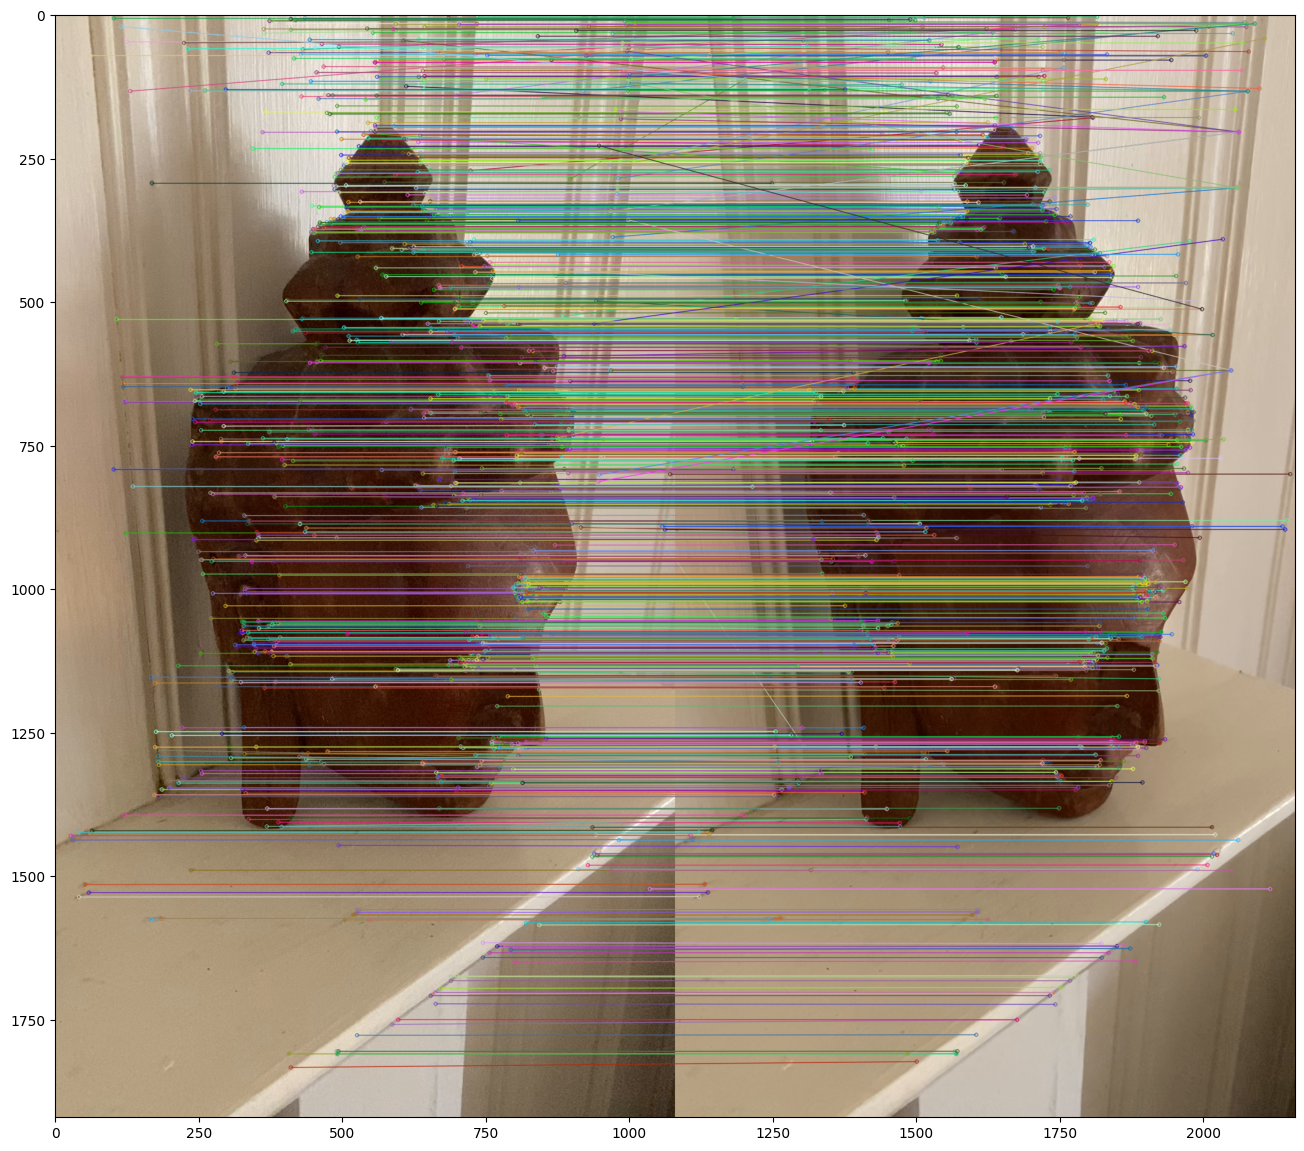

(<matplotlib.image.AxesImage at 0x7f44b8f5c790>, None)

In [6]:
img3 = cv2.drawMatches(imgs_norm[0],kp[0],imgs_norm[1],kp[1],goodMatchList[0],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize = (16,16))
plt.imshow(img3),plt.show()

In [7]:
epipolar_imgs = []
for i in range(len(imgs_gray)-1):
    # draw epipolar lines
    lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,Flist[i])
    lines1 = lines1.reshape(-1,3)
    img_left, _ = drawlines(imgs_gray[i],imgs_gray[i+1],lines1,pts1,pts2)

    lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,Flist[i])
    lines2 = lines2.reshape(-1,3)
    img_right, _ = drawlines(imgs_gray[i+1],imgs_gray[i],lines2,pts2,pts1)

    epipolar_imgs.append((img_left,img_right))

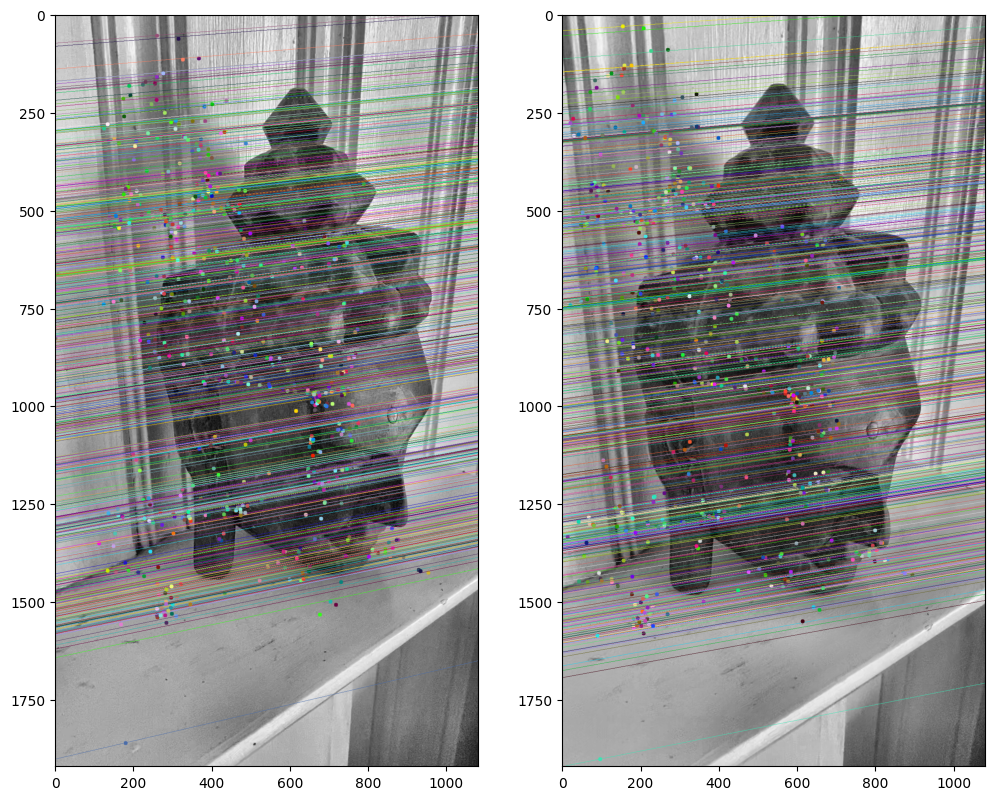

In [11]:
plt.figure(figsize = (12,12))
plt.subplot(121),plt.imshow(epipolar_imgs[1][0])
plt.subplot(122),plt.imshow(epipolar_imgs[1][1])
plt.show()

In [108]:
def optimal_triangulation(pts1, pts2, F):
    betterPts1, betterPts2 = cv2.correctMatches(F, pts1.reshape(1,-1,2), pts2.reshape(1,-1,2))
    return betterPts1, betterPts2

def getEssentialMat(pts1,pts2):
    E, mask = cv2.findEssentialMat(pts1,pts2,K,cv2.RANSAC,prob=0.9,threshold=1.0)

    # only select inlier points
    pts1 = pts1[mask.ravel()==1]
    pts2 = pts2[mask.ravel()==1]
    return E, mask, (pts1, pts2)

In [109]:
betterPts = []
for i in range(len(Flist)): 
    betterPts1, betterPts2 = optimal_triangulation(inlier_pts[i][0],inlier_pts[i][1],Flist[i])
    betterPts.append((betterPts1.squeeze(),betterPts2.squeeze()))

In [110]:
Elist = []
inlier_pts = []
for i in range(len(imgs_gray)-1):
    #E, mask, (pts1,pts2) = getEssentialMat(ptsList[i][0],ptsList[i][1])
    E, mask, (pts1,pts2) = getEssentialMat(betterPts[i][0],betterPts[i][1])
    Elist.append(E)
    inlier_pts.append((pts1,pts2))

In [111]:
len(inlier_pts[0][0]) 

180